# Cap inspection and preprocessing
@author Xiaowei Wen
email: xiaowei.wen@studio.unibo.it
A.Y. 2020/2021

Importing libraries and functions used for the project.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import measure
from skimage.measure import regionprops_table
from skimage.transform import rotate,probabilistic_hough_line
from math import  sqrt
import os
import pandas as pd

In following section, I will load the raw images, and the following operations will be done:
 - Cropping of the interested part of the image
 - Saving the original unblurred image
 - Blur the image with a Gaussian Filter
 - Save the blurred image

In [2]:

file_names = os.listdir("images")
file_names = ["images\{}".format(name) for name in file_names]

cb_images =list()
cropped_images= list()
original_images = list()
for file_name in file_names:
    image = cv2.imread(file_name)
    cropped_image= image[50:550,130:650]
    cropped_images.append(cropped_image.copy())
    # decomment the following line to see the result of the crop
    # plt.imshow(cropped_image, cmap="gray"), plt.show()
    blurred_image = cv2.GaussianBlur(cropped_image,(13,13),0)
    cb_images.append(blurred_image)

 

In the following cell I am going to define some functions that will be used to process the image.
More precisely, I will define three functions:
- find_best_circle;
- compute_centroid;
- compute_rotation_angle.

In [3]:
def find_best_circle(img):
    """
    returns circles found by hough circles
    """
    found_circles = cv2.HoughCircles(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY), cv2.HOUGH_GRADIENT,2.0,minDist=190,
                                    param1=104,param2=400,minRadius=220,maxRadius=250)
    if found_circles is not None:
        found_circles = np.round(found_circles[0, :]).astype("int")
        return found_circles

def compute_centroid(img,blob_area):
    """
        given an image with a blob and the area of the blob it computes the centroid of the blob.
    """
    x_accumulator = y_accumulator=0
    for index_i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[index_i,j]>= 60:
                x_accumulator += index_i
                y_accumulator += j 

    return int(np.rint(y_accumulator/blob_area)),int(np.rint(x_accumulator/blob_area))


def compute_rotation_angle(delta_x,delta_y):
    """
    given delta x and delta y, the difference of a point1 and point2, it computes how many degrees we have to rotate to have the point on the y-axis of the cartesian
    plane with origin exactly on the point2

    """
    res = np.arctan2(delta_y,delta_x)*180/np.pi
    if delta_y>=0 and delta_x>=0:
        return res+90
    elif delta_y>=0 and delta_x<=0:
        return res+90
    elif delta_y<=0 and delta_x>=0:
        return np.abs(90+res)
    elif delta_y<=0 and delta_x<=0:
        return res+90


In this cell, every cropped and blurred image, will be processed as the following description:
1. defining the center of the image as the center of circle, and this can be then updated with the center found with
```find_best_circle()``` function.
2. draw the circle found on the image.
3. by drawing the circle with black color, in the image, we can suppose there are the tab and some other small blobs left,
in order to make these as separated as possible, I did the following operations:
    - mean filter;
    - thresholding the image;
    - opening with an elliptical form structuring element;
    - erosion with an elliptical form structuring element;
4. for each remaining blob we compute the following properties:
    - ```area```,```perimeter```,```bbox```,```bbox_area```,```label```, ```compactness```, ```rectangularity```;
5. filter those one with ```area``` bigger than 500 and those smaller than 20 pixels.
6. sort the table by ```compactness```,```area```,```rectangularity``` respectively by
```ascending```, ```desceding```, ```ascending``` order.
7. pick the label of the first element, set all other pixels as background pixels, and compute the centroid of this blob;
8. compute the rotation angle respect to the centre of the circle using ```compute_rotation_angle```
and rotate the unblurred image;
9. crop the circular cavity number.

In [4]:
circular_cav_nums = list()
rotated_images= list()
centers = list()
for i in range(0,len(cb_images)):
    focus = cb_images[i].copy()
    original = cropped_images[i].copy()
    circles = find_best_circle(focus)

    tab = cv2.cvtColor(focus,cv2.COLOR_BGR2GRAY).copy()
    x_center = focus.shape[0]/2
    y_center = focus.shape[0]/2
    radius = 120
    for (x,y,r) in  circles:
        x_center = x
        y_center = y
        radius = r
        centers.append((x,y,r))
        # print("center has coordinate ({},{}), radius = {}".format(x,y,r))
        highlighted = cv2.circle(focus,(x,y),r,(0,255,255),1)
        original = cv2.circle(original,(x,y),r,(255,0,0),2)
        original = cv2.circle(original,(x,y),1,(255,0,0),2) # adding the centre of the circle
        tab = cv2.circle(tab,(x,y),r,(0,0,0),-1)

    opened = cv2.blur(tab,(5,5))
    
    opened = cv2.threshold(opened,70,255, type = cv2.THRESH_BINARY,)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    opened= cv2.morphologyEx(opened, cv2.MORPH_OPEN,kernel,-1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    opened = cv2.morphologyEx(opened,cv2.MORPH_ERODE,kernel,-1)
    
    
    labels = measure.label(opened)
    
    properties =['area','perimeter','bbox','bbox_area','label'
                #  'convex_area', 'major_axis_length', 'minor_axis_length', 'eccentricity',
            ]
    df = pd.DataFrame(regionprops_table(labels, properties = properties))
    df["compactness"]= df["perimeter"]**2/df["area"]
    df["rectangularity"] = df["area"]/df["bbox_area"]
        
    
    df= df[df["area"]>=20]
    df= df[df["area"]<=500]
    df=df.sort_values(["compactness","area",'rectangularity'], ascending=[True,False,True])

    best =df.iloc[0]['label']
    area = df.iloc[0]["area"]
    
    labels[labels==best]=255

    (x_tab,y_tab) = compute_centroid(labels,area)
    
    angle = compute_rotation_angle(x_tab-x_center,y_tab-y_center)

    # print("we need to rotate by {} degree".format(angle))    
    original =cv2.circle(original,(x_tab,y_tab),1,(255,0,0),1) # adding the barycenter of the centroid
    # original = cv2.line(original,(x_tab,y_tab),(x_center,y_center),(255,0,0),2) # drawing a segment with endpoints the centroid of the tab and the centre of the circle

    rotated_image= rotate(original,angle,resize=False)
    rotated_image = cv2.convertScaleAbs(rotated_image, alpha=255.0)
    rotated_images.append(rotated_image)

    # decomment the following line to have every rotated image printed.
    # plt.imshow(rotated_image,cmap="gray"), plt.show()
    circular_cavity_num = rotated_image[60:140, 180:350].copy()

    # decomment the following line to have every crop printed.
    # plt.imshow(circular_cavity_num,cmap="gray"), plt.show()
    circular_cav_nums.append(circular_cavity_num)
    
    # print("####################################")
   

In this cell I perform the polar transform of the tap, then crop the area containing the cavity number, then, crop the image again.

In [5]:
cavity_numbers = list()
for i in range(len(rotated_images)):
    image = rotated_images[i]
    (x,y,r) = centers[i]

    margin = 0.8 # Cut off the outer 10% of the image
    # Do the polar rotation along 1024 angular steps with a radius of radius pixels.
    polar_img = cv2.warpPolar(image, (r, 1024), (x,y), image.shape[1]*margin*0.7, cv2.WARP_POLAR_LINEAR)
    # Rotate it sideways to be more visually pleasing
    polar_img = cv2.rotate(polar_img, cv2.ROTATE_90_COUNTERCLOCKWISE)

    crop = polar_img[80:160,675:865].copy()

    cavity_numbers.append(crop)
    cavity_number = cv2.convertScaleAbs(crop, alpha=255.0)
    cv2.imwrite("cavity\Cavity_{}.bmp".format(i),cavity_number) #




As in the previous cell the cropped polar transformed image has the cavity number rotated, so I decided to rotate the image slightly again.
In order to do so, I computed the rotation angle based on the line present in the crop.


In [6]:
rectified_cav_nums = list()
for i in range (len(cavity_numbers)):
    crop = cavity_numbers[i]
    blurred_image = cv2.GaussianBlur(crop.copy(),(15,15),0)
    edges = cv2.Canny(blurred_image,threshold1= 20, threshold2=40)
    lines = probabilistic_hough_line(edges, threshold=50, line_length=10,
                                 line_gap=3)
    points = list()
    for l in lines:
        points.append(l[0])
        points.append(l[1])
      
    points= sorted(points,key=lambda item: item[1],reverse=False)
    
    if len(points)!=0:
        maxp = points[len(points)-1]
        minp= points[0]
        angle =np.arctan2(maxp[1]-minp[1],maxp[0]-minp[0])
        
        crop= rotate(crop,-angle)        
        crop = cv2.convertScaleAbs(crop, alpha=255.0)

    rectified_cav_num = crop[5:70,5:195].copy()
    rectified_cav_nums.append(rectified_cav_num)


Printing the obtained images, and saving them with proper names.

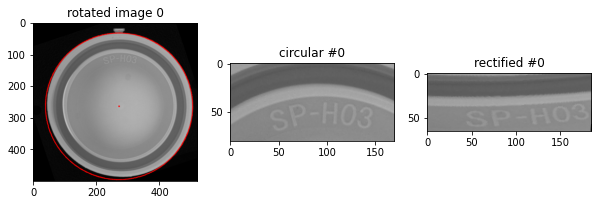

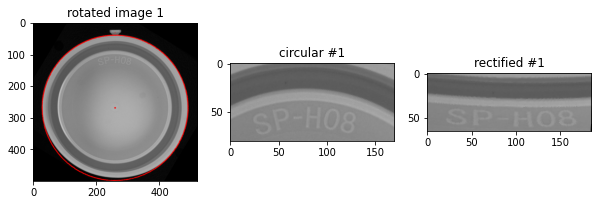

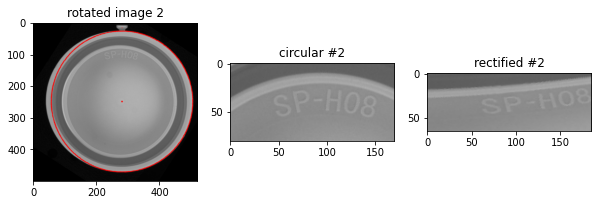

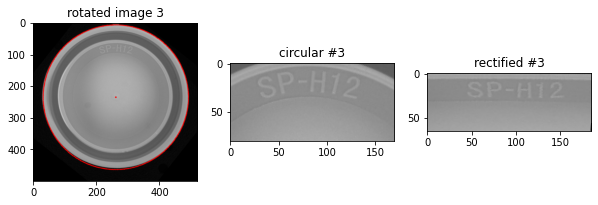

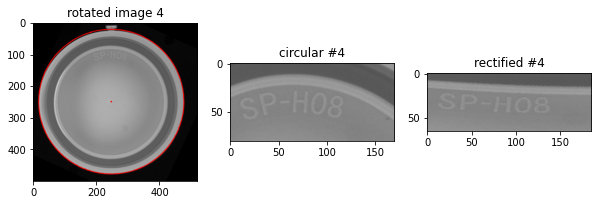

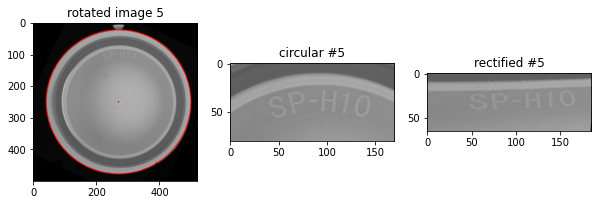

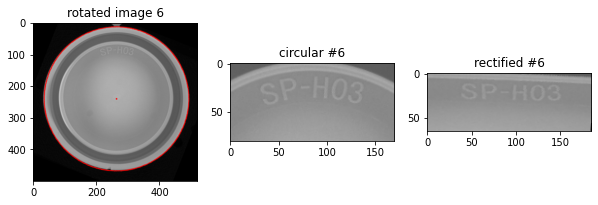

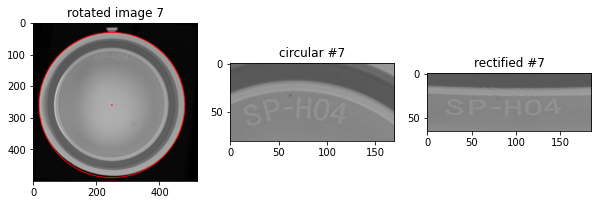

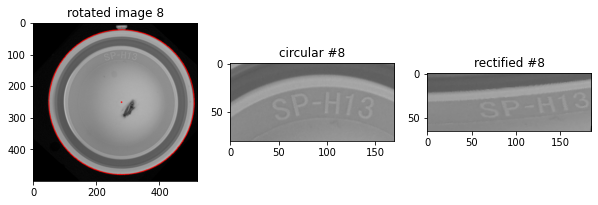

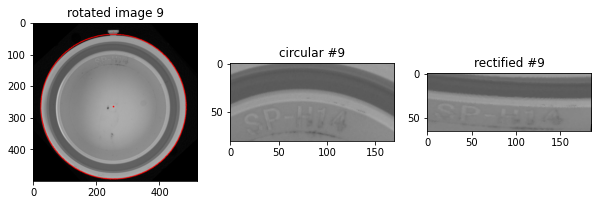

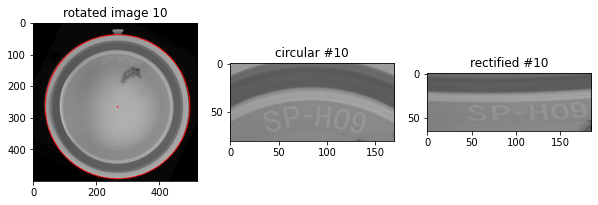

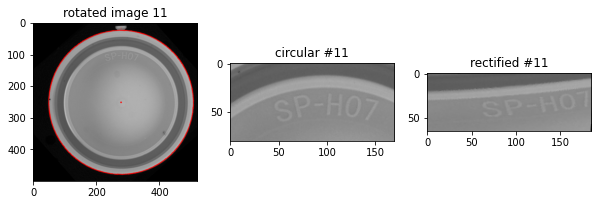

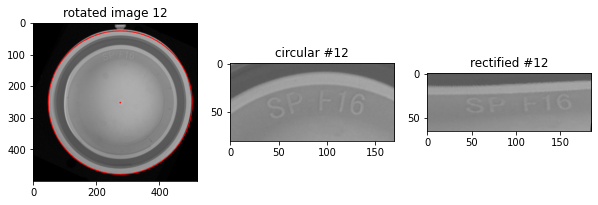

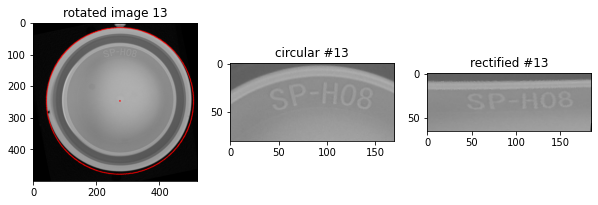

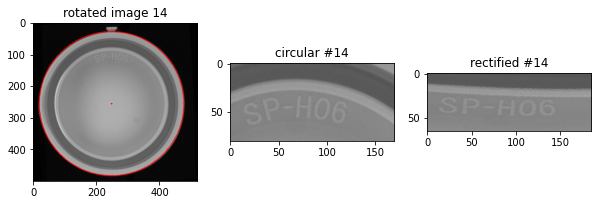

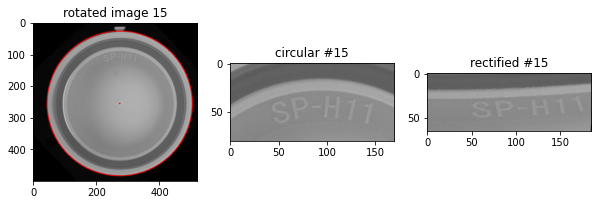

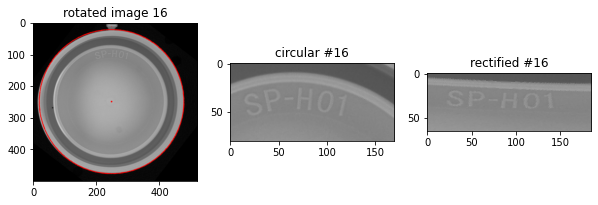

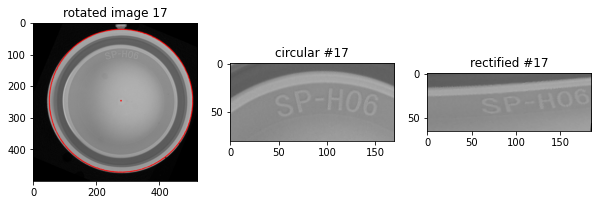

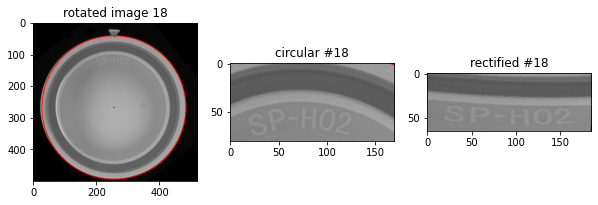

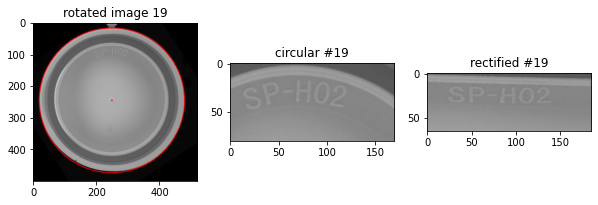

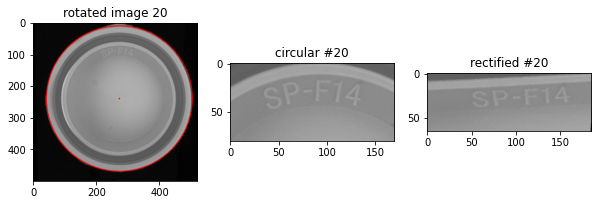

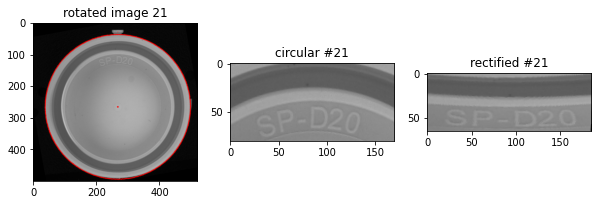

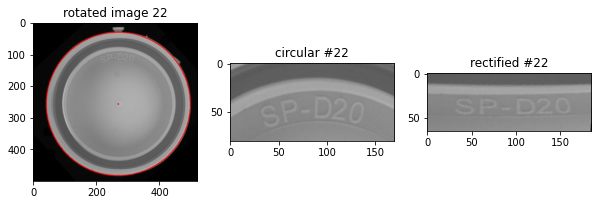

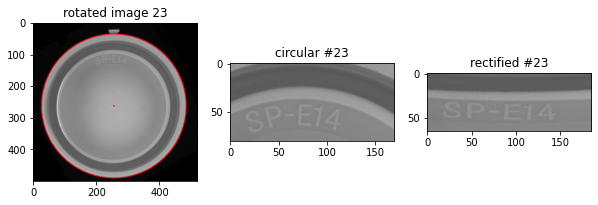

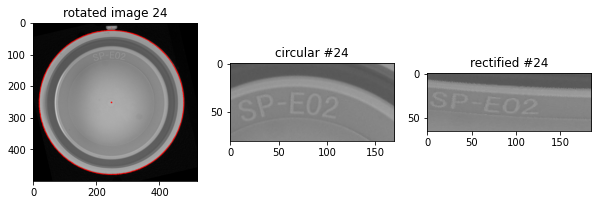

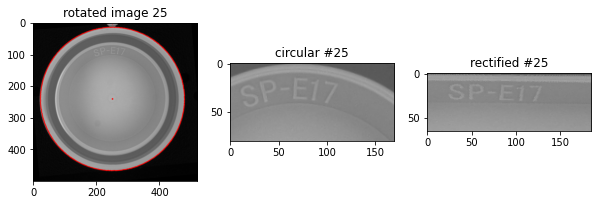

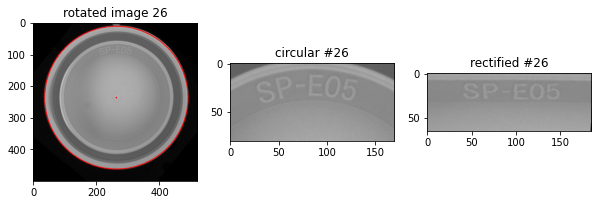

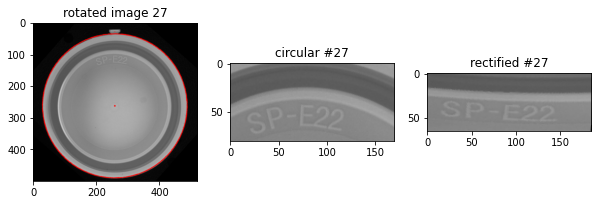

In [7]:

for i in range(len(rotated_images)):
    plt.figure(figsize=(10,15))
    rotated_image = rotated_images[i]
    circular_cavity_num = circular_cav_nums[i]
    rectified_cavity_num = rectified_cav_nums[i]
    cv2.imwrite("output\highlighted_{}.bmp".format(i), rotated_image)
    cv2.imwrite("output\circular_cavity_num_{}.bmp".format(i), circular_cavity_num)
    cv2.imwrite("output/rectified_cavity_num_{}.bmp".format(i),rectified_cavity_num)
    plt.subplot(1,3,1)
    plt.imshow(rotated_image,cmap="gray"),plt.title("rotated image {}".format(i))
    plt.subplot(1,3,2)
    plt.imshow(circular_cavity_num,cmap="gray"),plt.title("circular #{}".format(i))
    plt.subplot(1,3,3)
    plt.imshow(rectified_cavity_num,cmap="gray"),plt.title("rectified #{}".format(i)),plt.show()